# ***Deep Learning based Car Identification***
##### *- Automotive, Surveillance, Object Detection & Localisation*

***Project By:***<br>
Premjeet Kumar https://www.linkedin.com/in/premjeet-kumar/<br>
Hari Samynaath S https://www.linkedin.com/in/harinaathan/<br>
Veena Raju https://www.linkedin.com/in/veena-raju-1b16b513b/<br>
Javed Bhai https://www.linkedin.com/in/javedbhai/<br>
Surabhi Joshi https://www.linkedin.com/in/surabhi-joshi-4452788/<br>

***Project For:***<br>
Captstone project for **Post Graduate Program in Artificial Intelligence and Machine Learning**<br>
with *GreatLakes & Texas McCombs School of Business, The University of Texas at Austin*

**CONTEXT:**<br>
Computer vision can be used to automate supervision and generate action appropriate action trigger if the event is predicted from the image of interest. For example a car moving on the road can be easily identi ied by a camera as make of the car, type, colour, number plates etc.<br><br>
**DATA DESCRIPTION:**<br>
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.<br>
<br>
‣ *Train Images:* Consists of real images of cars as per the make and year of the car.<br>
‣ *Test Images:* Consists of real images of cars as per the make and year of the car.<br>
‣ *Train Annotation:* Consists of bounding box region for training images.<br>
‣ *Test Annotation:* Consists of bounding box region for testing images.<br>

### **MILESTONE 1:**
‣ *Step 1:* Import the data<br>
‣ *Step 2:* Map training and testing images to its classes.<br>
‣ *Step 3:* Map training and testing images to its annotations.<br>
‣ *Step 4:* Display images with bounding box<br>
‣ *Output:* Images mapped to its class and annotation ready to be used for deep learning<br>

### **MILESTONE 2:**
‣ *Input:* Output of milestone 1<br>
‣ *Step 1:* Design, train and test CNN models to classify the car.<br>
‣ *Step 2:* Design, train and test RCNN & its hybrids based object detection models to impose the bounding box or
mask over the area of interest.<br>
‣ *Output:* Pickled model to be used for future prediction<br>

### **Attempt of transfer learning based on NASNetMobile**

In [1]:
from lib.networkPipe import Pipe

Metal device set to: Apple M1 Pro


2022-07-29 16:46:25.057348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-29 16:46:25.057462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
logdir = "logs"
%load_ext tensorboard
%tensorboard --logdir logs

In [3]:
# define a transfer learning network mapped to our targets
def transferNET(application,input_size):    
    
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input,GlobalMaxPool2D,Dense,BatchNormalization,Dropout
    
     # Random consistency seed
    tf.random.set_seed(100)
    
    # load application
    tNet = application(input_shape=input_size[1:],include_top=False, weights='imagenet')
    
    # flatten with pooling
    pool = GlobalMaxPool2D(name="CustomLayerStart")(tNet.output)
    
    # classifier branch for car names
    nameBranch = Dense(512,activation='relu')(pool)
    Nbn1 = BatchNormalization()(nameBranch)
    Ndo1 = Dropout(0.3)(Nbn1)
    Nhid1 = Dense(256,activation='relu')(Ndo1)
    Nbn2 = BatchNormalization()(Nhid1)
    Ndo2 = Dropout(0.3)(Nbn2)
    classifier = Dense(196,activation='softmax',name="names")(Ndo2)
    
    # regression branch for bounding boxes
    boxBranch = Dense(64,activation='relu')(pool)
    Bbn1 = BatchNormalization()(boxBranch)
    Bdo1 = Dropout(0.3)(Bbn1)
    Bhid1 = Dense(32,activation='relu')(Bdo1)
    Bbn2 = BatchNormalization()(Bhid1)
    Bdo2 = Dropout(0.3)(Bbn2)
    bBox = Dense(4,activation='relu',name="boxes")(Bdo2)
    
    # assemble the network
    model = Model(inputs=tNet.inputs,outputs=[classifier,bBox])
    
    # freeze application layers and open classifer & regressor for training
    for layer in model.layers[:-15]:
        layer.trainable = False
    
    return model

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.nasnet import NASNetMobile

In [5]:
gPoint = {'width':224,
          'optimizer':Adam,
          'patience':5,'slope':0.3,'factor':0.1,
          'unFreezeRatio':None,
          'learning_rate':1e-3,'lossBalance':0.5}

In [6]:
# generator parameters
dims = (gPoint.get('width'),gPoint.get('width'))
gParams = dict(target_size=dims,batch_size=32)
# model creation parameters
mParams = dict(application=NASNetMobile)
# optimiser for compilation
optim = gPoint.get('optimizer')
# lr scheduler parameters
lrParams = dict(patience=gPoint.get('patience'),slope=gPoint.get('slope'),factor=gPoint.get('factor'))
# earlyStop parameters
eSparams = dict(patience=int(gPoint.get('patience')*3.1),slope=gPoint.get('slope')*0.5)
# model fitting parameters
fParams = dict(epochs=30,verbose=1)
# trainability scheduler parameters
if gPoint.get('unFreezeRatio')==None:
    trParams = dict() 
else:
    trParams = dict(uncontrolled=-15,schedule={int(gPoint.get('patience')*2.8):gPoint.get('unFreezeRatio')})
# other hyper parameters
lRate = gPoint.get('learning_rate')
lBalance = gPoint.get('lossBalance')
gridPoint = dict(learning_rate=lRate,lossWeights={'names':lBalance,'boxes':1-lBalance})

imScanTest: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:03<00:00, 55.14it/s]


20004864/19993432 [==============================] - 1s 0us/step
Epoch 1/30


2022-07-29 16:46:56.075621: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-29 16:47:01.339503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


229/229 [==============================] - ETA: 0s - loss: 4.9830 - names_loss: 4.6173 - boxes_loss: 0.3657 - names_CategoricalAccuracy: 0.0590 - names_Precision: 0.2697 - names_Recall: 0.0056 - boxes_IoU: -0.9186

2022-07-29 16:49:17.559699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


229/229 [==============================] - 161s 634ms/step - loss: 4.9830 - names_loss: 4.6173 - boxes_loss: 0.3657 - names_CategoricalAccuracy: 0.0590 - names_Precision: 0.2697 - names_Recall: 0.0056 - boxes_IoU: -0.9186 - val_loss: 3.9399 - val_names_loss: 3.8123 - val_boxes_loss: 0.1275 - val_names_CategoricalAccuracy: 0.1100 - val_names_Precision: 0.4062 - val_names_Recall: 0.0162 - val_boxes_IoU: 0.2624 - learning_rate: 0.0010 - Trainable: 15.0000 - lapTime: 160.3005
Epoch 2/30
229/229 [==============================] - 147s 639ms/step - loss: 3.8665 - names_loss: 3.7121 - boxes_loss: 0.1544 - names_CategoricalAccuracy: 0.1332 - names_Precision: 0.4382 - names_Recall: 0.0160 - boxes_IoU: 0.2154 - val_loss: 3.6554 - val_names_loss: 3.6166 - val_boxes_loss: 0.0388 - val_names_CategoricalAccuracy: 0.1512 - val_names_Precision: 0.2787 - val_names_Recall: 0.0213 - val_boxes_IoU: 0.4835 - learning_rate: 0.0010 - Trainable: 15.0000 - lapTime: 145.6646
Epoch 3/30
229/229 [================

Epoch 18/30
229/229 [==============================] - ETA: 0s - loss: 1.4878 - names_loss: 1.4742 - boxes_loss: 0.0136 - names_CategoricalAccuracy: 0.6120 - names_Precision: 0.8937 - names_Recall: 0.3420 - boxes_IoU: 0.6301

---------------------------------------------------------------
eStop initiated after epoch  17 for poor loss gradient of 0.132
---------------------------------------------------------------

229/229 [==============================] - 151s 660ms/step - loss: 1.4878 - names_loss: 1.4742 - boxes_loss: 0.0136 - names_CategoricalAccuracy: 0.6120 - names_Precision: 0.8937 - names_Recall: 0.3420 - boxes_IoU: 0.6301 - val_loss: 2.8261 - val_names_loss: 2.8154 - val_boxes_loss: 0.0107 - val_names_CategoricalAccuracy: 0.2937 - val_names_Precision: 0.5988 - val_names_Recall: 0.1250 - val_boxes_IoU: 0.6622 - learning_rate: 1.0000e-05 - Trainable: 15.0000 - lapTime: 151.2552

----------
EVALUATION
----------

251/251 [==============================] - 135s 540ms/step - loss:

2022-07-29 17:35:26.368408: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./deployables/NASNetMobile/NASNetMobile/tfsave/assets


,name,target_size,batch_size,optimizer,patience,slope,factor,learning_rate,lossWeights,epochs,verbose,logs,loss,names_loss,boxes_loss,names_CategoricalAccuracy,names_Precision,names_Recall,boxes_IoU,val_loss,val_names_loss,val_boxes_loss,val_names_CategoricalAccuracy,val_names_Precision,val_names_Recall,val_boxes_IoU
0,NASNetMobile,"(224, 224)",32,Adam,15,0.15,0.1,0.001,"{'names': 0.5, 'boxes': 0.5}",30,1,"{'loss': [4.982983589172363, 3.866465091705322...",1.269307,1.258898,0.010408,0.728716,0.958167,0.414247,0.667567,2.815521,2.80481,0.01071,0.305154,0.639756,0.117405,0.665775



----------
PREDICTION
----------



2022-07-29 17:36:06.299654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


251/251 [==============================] - 134s 535ms/step


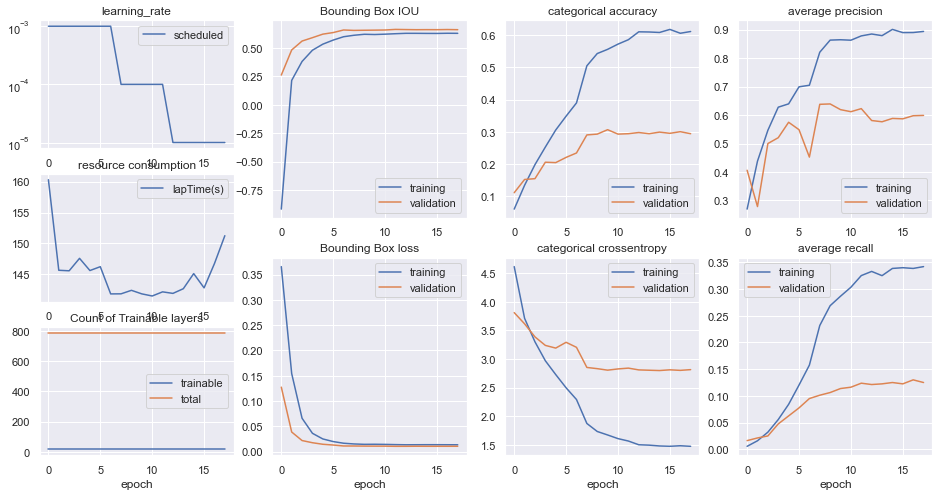

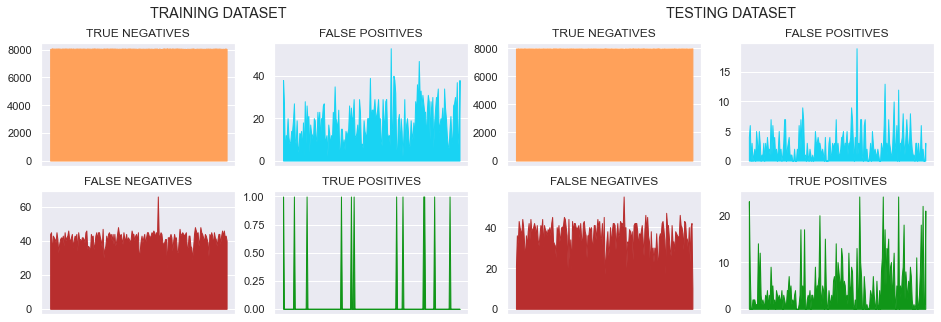

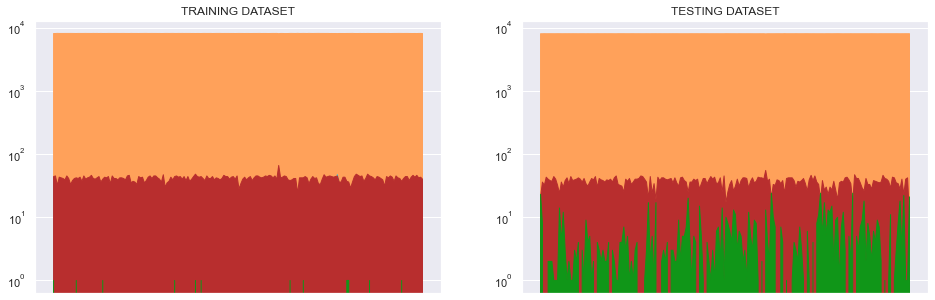

samples from TRAINING SET


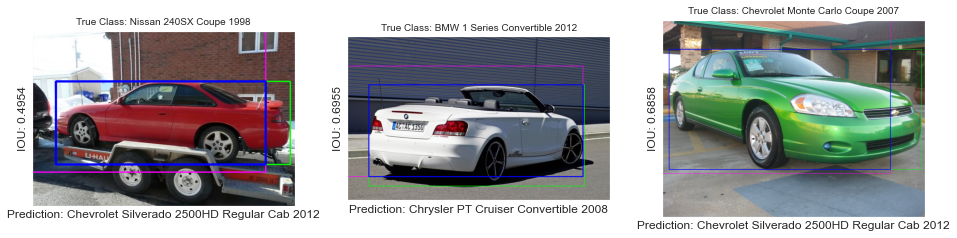

samples from TESTING SET


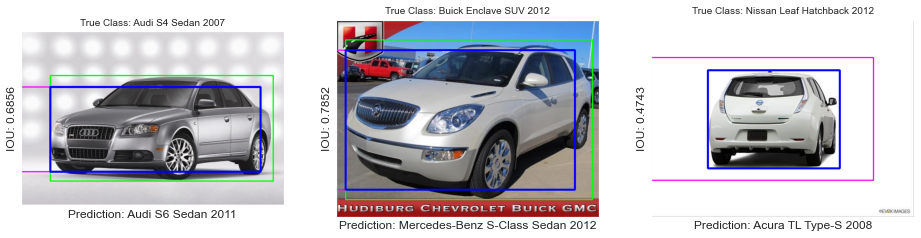

In [7]:
pp = Pipe(generatorParams=gParams,modelFunc=transferNET,
          modelName="NASNetMobile",modelParams=mParams)
pp.compiler(optim=Adam(),lrScheduleParams=lrParams,eStopParams=eSparams,
            trainabilityParams=trParams,gridPoint=gridPoint,sBest=True)
pp.fit(gridPoint=gridPoint,fitParams=fParams)
pp.evaluate()
pp.save()
pp.report()